In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
L = 1.0
nx = 51
dx = L / (nx - 1)
alpha = 1.22e-3

x = numpy.linspace(0.0, L, num=nx)

T0 = numpy.zeros(nx)
T0[0] = 100.0

In [4]:
def ftcs(T0, nt, dt, dx, alpha):
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
    return T

In [5]:
nt = 100
sigma = 0.5
dt = sigma * dx**2 / alpha


T = ftcs(T0, nt, dt, dx, alpha)

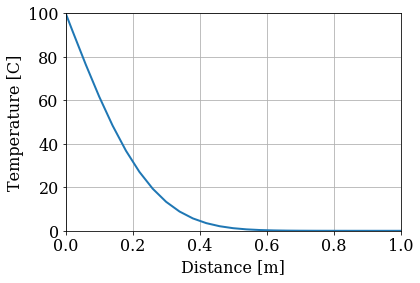

In [6]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [7]:
nt = 1000

T = ftcs(T0, nt, dt, dx, alpha)

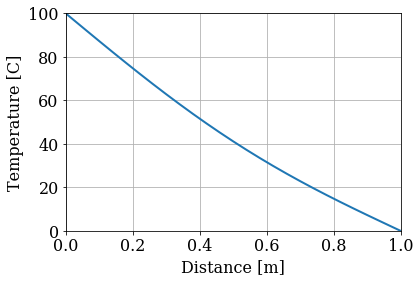

In [8]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [9]:
def ftcs_mixed_bcs(T0, nt, dt, dx, alpha):
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
        # Apply Neumann condition at the last location.
        T[-1] = T[-2]
    return T

In [10]:
nt = 1000

T = ftcs_mixed_bcs(T0, nt, dt, dx, alpha)

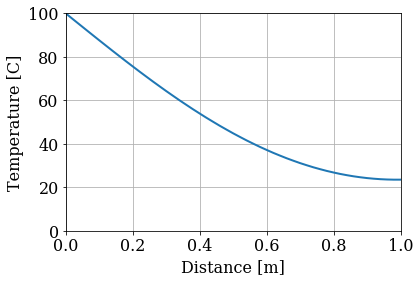

In [11]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);